In [128]:
# Imports & Inits

from datetime import datetime
from datetime import timezone
import polars as pl
import asyncpg
import pendulum
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import math
import pyarrow as pa
import numpy as np
import os

quickflow_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"

df_quickflow = pl.scan_parquet(os.path.join(quickflow_directory, "measurements.parquet")) 

def plot_sensor_measurement(df, variant: str, col_name: str, sensor_id: list=[], filter = None):

        for id in sensor_id:
                df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 0).select(pl.col("date",col_name))
                
                if filter != None:
                        df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

                sns.lineplot(data=df_f,
                        x='date',
                        y=col_name,
                        label = id)


        # set axes labels
        plt.xlabel('Time')
        plt.ylabel(col_name)
        plt.xticks(rotation=45)
        plt.legend(title='Systems', bbox_to_anchor=(1, 1))
        plt.title(label=col_name)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

        # show the plot
        plt.show()
        
def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

def average_bottle(conc_list):
    uncut_avg = sum(conc_list) / len(conc_list)
    print(f"Uncut average: {uncut_avg}")

    if len(conc_list) > 0:
        conc_list_cut = conc_list[int(len(conc_list)*0.3):int(len(conc_list)*0.95)]
        cut_avg = sum(conc_list_cut) / len(conc_list_cut)
        print(f"Cut average: {cut_avg}")
    
        return cut_avg
    return 0

def extract_calibration_period(start_date, end_date):
    data = {
        "integer": [],
        "date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": [],
        "speed_avg": [],
        "speed_max": [],
        "speed_min": [],
        "direction_avg": [],
        "direction_max": [],
        "direction_min": [],
        "last_update_time": [],
        "cpu_usage": [],
        "disk_usage": [],
        #"memory_usage": [],
        "cpu_temperature": [],
        "enclosure_humidity": [],
        "enclosure_pressure": [],
        "mainboard_temperature": [],
        }

    # loop through the quickflow dataset and sort it into dataframe
    df_q = df_quickflow.select(pl.col("creation_timestamp","sensor_name","value")).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

    for n, payload in enumerate(df_q.iter_rows()):
        creation_timestamp = payload[0]
        sensor_name = payload[1]
        entry = json.loads(payload[2])
        
        try:
        
            if entry["variant"] in ("measurement","calibration"):
                #variant measurement & calibrtion
                data["CO2_raw"].append(entry["data"]["raw"])
                data["CO2_compensated"].append(entry["data"]["compensated"])
                data["CO2_filtered"].append(entry["data"]["compensated"])
                data["sht45_humidity"].append(entry["data"]["sht45_humidity"])
                data["bme280_humidity"].append(entry["data"]["bme280_humidity"])
                data["bme280_pressure"].append(entry["data"]["bme280_pressure"])
                data["sht45_temperature"].append(entry["data"]["sht45_temperature"])
                data["bme280_temperature"].append(entry["data"]["bme280_temperature"])
                data["chamber_temperature"].append(entry["data"]["chamber_temperature"])
                if entry["variant"] == "calibration":
                        data["gas_bottle_id"].append(entry["data"]["gas_bottle_id"])
                else:
                        data["gas_bottle_id"].append(None)
                # variant wind     
                data["speed_avg"].append(None)
                data["speed_max"].append(None)
                data["speed_min"].append(None)
                data["direction_avg"].append(None)
                data["direction_max"].append(None)
                data["direction_min"].append(None)
                data["last_update_time"].append(None)
                # variant system
                data["cpu_usage"].append(None)
                data["disk_usage"].append(None)
                #data["memory_usage"].append(None)
                data["cpu_temperature"].append(None)
                data["enclosure_humidity"].append(None)
                data["enclosure_pressure"].append(None)
                data["mainboard_temperature"].append(None)
                # base
                data["integer"].append(n)
                data["date"].append(creation_timestamp)
                data["system name"].append(sensor_name)
                data["variant"].append(entry["variant"])
                
            if entry["variant"] == "wind":
                #variant measurement & calibrtion
                data["CO2_raw"].append(None)
                data["CO2_compensated"].append(None)
                data["CO2_filtered"].append(None)
                data["sht45_humidity"].append(None)
                data["bme280_humidity"].append(None)
                data["bme280_pressure"].append(None)
                data["sht45_temperature"].append(None)
                data["bme280_temperature"].append(None)
                data["chamber_temperature"].append(None)
                data["gas_bottle_id"].append(None)
                # variant wind
                data["speed_avg"].append(entry["data"]["speed_avg"])
                data["speed_max"].append(entry["data"]["speed_max"])
                data["speed_min"].append(entry["data"]["speed_min"])
                data["direction_avg"].append(entry["data"]["direction_avg"])
                data["direction_max"].append(entry["data"]["direction_max"])
                data["direction_min"].append(entry["data"]["direction_min"])
                data["last_update_time"].append(entry["data"]["last_update_time"])
                # variant system
                data["cpu_usage"].append(None)
                data["disk_usage"].append(None)
                #data["memory_usage"].append(None)
                data["cpu_temperature"].append(None)
                data["enclosure_humidity"].append(None)
                data["enclosure_pressure"].append(None)
                data["mainboard_temperature"].append(None)
                # base
                data["integer"].append(n)
                data["date"].append(creation_timestamp)
                data["system name"].append(sensor_name)
                data["variant"].append(entry["variant"])
                
            if entry["variant"] == "system":
                #variant measurement & calibrtion
                data["CO2_raw"].append(None)
                data["CO2_compensated"].append(None)
                data["CO2_filtered"].append(None)
                data["sht45_humidity"].append(None)
                data["bme280_humidity"].append(None)
                data["bme280_pressure"].append(None)
                data["sht45_temperature"].append(None)
                data["bme280_temperature"].append(None)
                data["chamber_temperature"].append(None)
                data["gas_bottle_id"].append(None)
                # variant wind
                data["speed_avg"].append(None)
                data["speed_max"].append(None)
                data["speed_min"].append(None)
                data["direction_avg"].append(None)
                data["direction_max"].append(None)
                data["direction_min"].append(None)
                data["last_update_time"].append(None)
                # variant system
                data["cpu_usage"].append(entry["data"]["cpu_usage"])
                data["disk_usage"].append(entry["data"]["disk_usage"])
                #data["memory_usage"].append(entry["data"]["memory_usage"])
                data["cpu_temperature"].append(entry["data"]["cpu_temperature"])
                data["enclosure_humidity"].append(entry["data"]["enclosure_humidity"])
                data["enclosure_pressure"].append(entry["data"]["enclosure_pressure"])
                data["mainboard_temperature"].append(entry["data"]["mainboard_temperature"])
                # base
                data["integer"].append(n)
                data["date"].append(creation_timestamp)
                data["system name"].append(sensor_name)
                data["variant"].append(entry["variant"])
            
        except:
            print(payload)
            
                
        
            
    df = pl.DataFrame(data)
    return df.clone()

# Before Site-by-Site

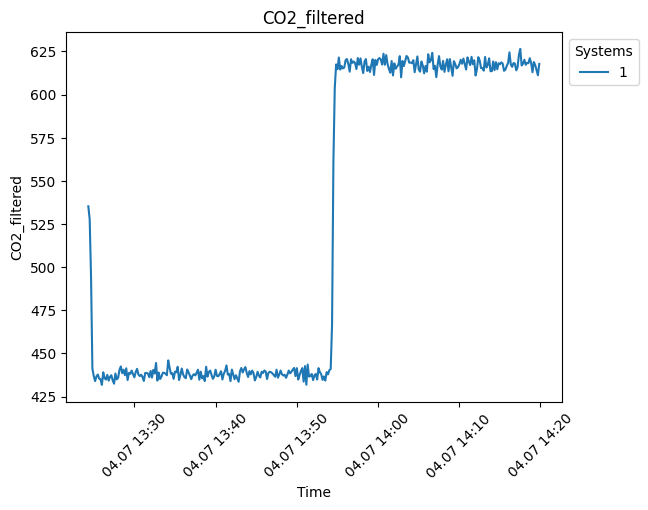

In [76]:
sensor_id = [1]

#calibration time
start_date = datetime(2023, 7, 4, 13, 20, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 4, 14, 20, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [ ]:
sensor_id = [11]

#calibration time
start_date = datetime(2023, 7, 3, 8, 40, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 3, 9, 40, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

# Before Deployment

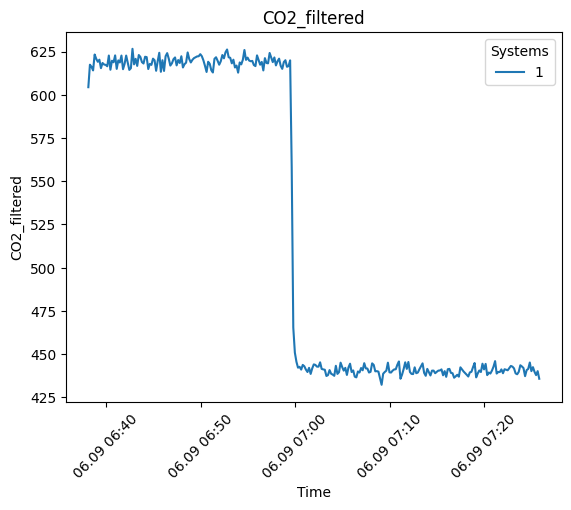

In [173]:
sensor_id = [1]

#calibration time
start_date = datetime(2023, 9, 6, 6, 38, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 6, 7, 26, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [175]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


618.6330769230766
619.4761904761906
440.85414012738846
440.40000000000015


(1.0250943998298148, -24.071573685050566)

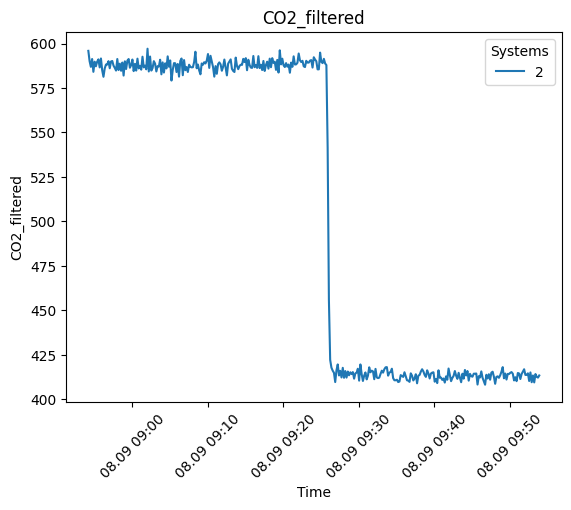

In [178]:
sensor_id = [2]

#calibration time
start_date = datetime(2023, 9, 8, 8, 54, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 8, 9, 54, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [179]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


588.1236842105264
588.087804878049
414.4171597633138
412.93181818181824


(1.0480372578892292, -5.387930422486534)

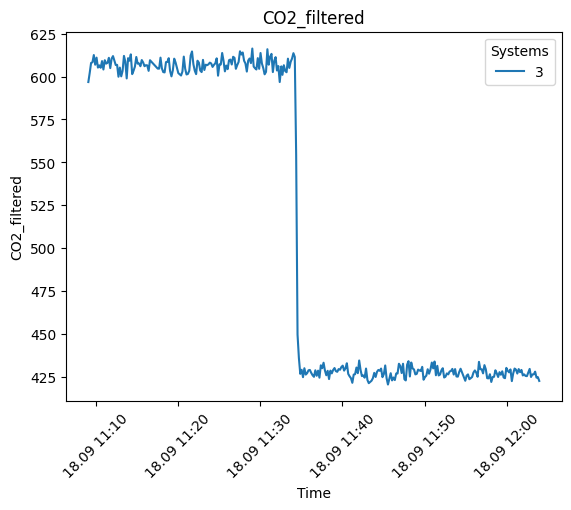

In [180]:
sensor_id = [3]

#calibration time
start_date = datetime(2023, 9, 18, 11, 9, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 18, 12, 4, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [181]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


606.5527027027026
606.7843750000001
427.6891428571429
427.37368421052605


(1.0231831737129127, -9.90156257190614)

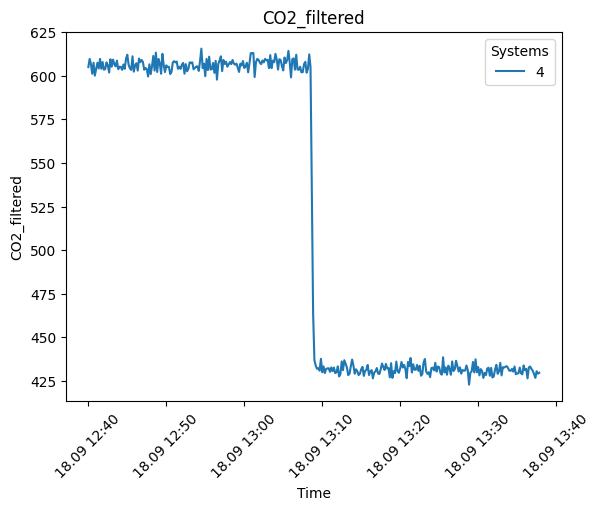

In [183]:
sensor_id = [4]

#calibration time
start_date = datetime(2023, 9, 18, 12, 40, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 18, 13, 38, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [184]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id[0]}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


606.3494186046512
606.655357142857
432.1545454545457
431.4330434782609


(1.0476405439513985, -24.60674834817263)